# Homework 7 

In [261]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

# **** import CenterOfMass to determine the COM pos/vel of M33
from CenterOfMass2 import CenterOfMass 

# **** import the GalaxyMass to determine the mass of M31 for each component
from GalaxyMass import ComponentMass


# M33AnalyticOrbit

In [309]:

class M33AnalyticOrbit:
    ''' Calculate the analytical orbit of M33 around M31 '''
    
    def __init__(self,filename):
        '''
        Function that defines class variables
        INPUTS:
            filename = 'string', name of file where the orbit data will be stored
        '''

        ### get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value

        ### store the output file name
        self.filename = filename
        
        # set tolerance and VolDec for calculating COM_P in CenterOfMass
        delta = 0.1
        volDec31 = 2
        volDec33 = 4 
        
        # initialize instance of COM for M33 and M31
        M33_COMnow = CenterOfMass('M33_000.txt', 2)
        M31_COMnow = CenterOfMass('M31_000.txt', 2)

        # get the current pos/vel of M33 and M31
        self.M33r = M33_COMnow.COM_P(delta,volDec33)
        self.M31r = M31_COMnow.COM_P(delta,volDec31)

        self.M33v = M33_COMnow.COM_V(self.M33r[0],self.M33r[1],self.M33r[2])
        self.M31v = M31_COMnow.COM_V(self.M31r[0],self.M31r[1],self.M31r[2])
        
        
        # store the difference between the vectors posM33 - posM31
        self.r0 = (self.M33r-self.M31r).value
        self.v0 = (self.M33v-self.M31v).value
        
        # get the mass and radius of each component in M31 
        # disk:
        self.rdisk = 5 #kpc
        self.Mdisk = ComponentMass('M31_000.txt',2)*1e12 
        
        # bulge:
        self.rbulge = 1 #kpc
        self.Mbulge = ComponentMass('M31_000.txt',3)*1e12
        
        # halo:
        self.rhalo = 61.58 #kpc
        self.Mhalo = ComponentMass('M31_000.txt',1)*1e12
        
    
    def HernquistAccel(self,M,r_a,r): 
        '''
        Function that calculates the Hernquist acceleration for 
        halo and bulge galaxy components
        INPUTS:
            M = 'float', mass of galaxy component
            r_a = 'float', Hernquist profile scale height of component
            r = position vector
        OUTPUTS:
            Hern = Hernquist acceleration vector 
        '''
        
        # store the magnitude of the position vector
        rmag = np.sqrt(r[0]**2+r[1]**2+r[2]**2)
        
        # define parts of the equation
        G = self.G
        n = G*M       #numerator
        d = rmag*((r_a+rmag)**2) #denominator

        # Hernquist acceleration
        Hern =  -n/d*r  
        
        return Hern
    
    
    def MiyamotoNagaiAccel(self,M,r_d,r):# it is easiest if you take as an input a position VECTOR  r 
        '''
        Function that calculates the Miyamoto-Nagai acceleration for 
        the galaxy disk
        INPUTS:
            M = 'float', mass of galaxy component
            r_d = 'float', disk radius
            r = position vector
        OUTPUTS:
            MN = Miyamoto-Nagai acceleration vector 
        '''

        # define parts of the equation
        G = self.G
        R = np.sqrt(r[0]**2+r[1]**2)
        z_d = r_d/0.5
        B = r_d+np.sqrt(r[2]**2+z_d**2)
        n = G*M*np.array([1,1,B/np.sqrt(r[2]**2+z_d**2)])    #numerator
        d = (R**2+B**2)**1.5      #denominator

        # Miyamoto-Nagai acceleration
        MN = -n/d*r
       
        return MN
     
    
    def M31Accel(self,r): # input should include the position vector, r
        '''
        Function that calculates the total acceleration of M31
        INPUTS:
            r = position vector
        OUTPUTS:
            tot_acc = total acceleration vector 
        '''
        # find accelertaion of each component of M31
        halo_acc = self.HernquistAccel(self.Mhalo,self.rhalo,r) 
        bulge_acc = self.HernquistAccel(self.Mbulge,self.rbulge,r)
        disk_acc = self.MiyamotoNagaiAccel(self.Mdisk,self.rdisk,r)

        # make acceleration vectors numpy arrays
        ah, ab, ad = np.array(halo_acc), np.array(bulge_acc), np.array(disk_acc)
        
        # sum vectors
        tot_acc = halo_acc+bulge_acc+disk_acc
            
        return tot_acc
    
        
    def LeapFrog(self,dt,r,v): 
        '''
        Function that performs leaf frog integration to find 
        position and velocity vector components at future timesteps
        INPUTS:
            dt = 'float', timestep size
            r = position vector
            v = velocity vector
        OUTPUTS:
            rnew = position vector at next full timestep
            vnew = velocity vector at next full timestep
        '''
        
        # predict the position at the next half timestep
        rhalf = r+v*(dt/2)
        
        # predict the final velocity at the next timestep using the acceleration field at the rhalf position 
        ahalf = self.M31Accel(rhalf)
        vnew = v+ahalf*dt
        
        # predict the final position using the average of the current velocity and the final velocity
        rnew = rhalf+vnew*(dt/2)
        
        return rnew, vnew 
    
    
    def OrbitIntegration(self, t0, dt, tmax):
        '''
        Function that integrates position and velocity with respect to 
        time and saves the resulting vectors at each timestep to a designated file
        INPUTS:
            dt = 'float', timestep size
            r = position vector
            v = velocity vector
        OUTPUTS:
            rnew = position vector at next full timestep
            vnew = velocity vector at next full timestep
        '''

        # starting time and pos/vel vectors
        t = t0
        r = self.r0
        v = self.v0
        
        # initialize an empty array 
        orbit = np.zeros((int(tmax/dt)+2,7))
        
        # initialize the first row of the orbit
        orbit[0] = t0, *tuple(r), *tuple(v)
       
        # initialize a counter for the orbit.  
        i = 1

        # start the integration 
        while (t <= tmax):  # as long as t has not exceeded the maximal time 
            
            # advance the time by one timestep
            t = t+dt
           
            # store the new time in the first column of the ith row
            #orbit[i,0] = t
            
            # advance the position and velocity using the LeapFrog scheme            
            r, v = self.LeapFrog(dt,r,v) 
            orbit[i] = t, *tuple(r), *tuple(v)
        
            #store the new position and velocity vectors into columns of the ith row of orbit
            # orbit[i,1],orbit[i,2],orbit[i,3] = r[0],r[1],r[2]
            # orbit[i,4],orbit[i,5],orbit[i,6] = v[0],v[1],v[2]
            
            # update counter i
            i += 1
        
        # write the data to a file
        np.savetxt(self.filename, orbit, fmt = "%11.3f"*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))        
        

In [311]:
# initialize instance of the M33AnalyticOrbit class
M33orbit = M33AnalyticOrbit('M33_AnalyticOrbit.txt')

# integrate orbit and save data file
M33orbit.OrbitIntegration(0,0.1,10)
    

M31 disk mass: 0.12 x 10^12 solmasses
M31 bulge mass: 0.019 x 10^12 solmasses
M31 dark matter halo mass: 1.921 x 10^12 solmasses


# Plotting seperation and relative velocity code from Homework 6

In [462]:

# define output files of each galaxy
MWfile = 'Orbit_MW.txt'
M31file = 'Orbit_M31.txt'
M33file = 'Orbit_M33.txt'

# read in the data files for the orbits of each galaxy
MWdata = np.genfromtxt(MWfile,dtype=None,names=True,skip_header=0,usecols=(0,1,2,3,4,5,6))
M31data = np.genfromtxt(M31file,dtype=None,names=True,skip_header=0,usecols=(0,1,2,3,4,5,6))
M33data = np.genfromtxt(M33file,dtype=None,names=True,skip_header=0,usecols=(0,1,2,3,4,5,6))
M33diffpos = np.genfromtxt('M33_AnalyticOrbit.txt',dtype=None,names=True,skip_header=0,usecols=(0,1,2,3,4,5,6))


# function to compute the magnitude of the difference between two vectors 
# You can use this function to return both the relative position and relative velocity for two 
def VectorDiff(p1,p2,v1,v2):
    '''
    Function to compute the magnitude of the difference
    between two vectors.

    inputs: p1 = position vector of first source (array)
    p2 = position vector of second source (array)
    v1 = velocity vector of first source (array)
    v2 = velocity vector of second source (array)

    outputs: pos_mag = magnitude of position seperation
    vel_mag = magnitude of relative velocity
    '''
    
    x = p2[0]-p1[0]
    y = p2[1]-p1[1]
    z = p2[2]-p1[2]
    pos_mag = np.sqrt(x**2+y**2+z**2)
    
    vx = v2[0]-v1[0]
    vy = v2[1]-v1[1]
    vz = v2[2]-v1[2]
    vel_mag = np.sqrt(vx**2+vy**2+vz**2)

    return pos_mag, vel_mag

# Determine the magnitude of the relative position and velocities 

# initialize lists to store position and velocity vector components
sep1 = []
vel1 = []
sep2 = []
vel2= []

# loop through galaxy data to find position and velocity vectors
for i in range(len(MWdata)):
    # position components of MW
    MWx= MWdata[i][1]
    MWy = MWdata[i][2]
    MWz = MWdata[i][3]
    MW_pos = np.array([MWx,MWy,MWz]) # position vector

    # velocity components of MW
    MWvx= MWdata[i][4]
    MWvy = MWdata[i][5]
    MWvz = MWdata[i][6]
    MW_vel = np.array([MWvx,MWvy,MWvz]) # velocity vector

    # position components of M31
    M31x= M31data[i][1]
    M31y = M31data[i][2]
    M31z = M31data[i][3]
    M31_pos = np.array([M31x,M31y,M31z]) # position vector

    # velocity components of M31
    M31vx= M31data[i][4]
    M31vy = M31data[i][5]
    M31vz = M31data[i][6]
    M31_vel = np.array([M31vx,M31vy,M31vz]) # velocity vector

    # position components of M33
    M33x= M33data[i][1]
    M33y = M33data[i][2]
    M33z = M33data[i][3]
    M33_pos = np.array([M33x,M33y,M33z]) # position vector

    # velocity components of M33
    M33vx= M33data[i][4]
    M33vy = M33data[i][5]
    M33vz = M33data[i][6]
    M33_vel = np.array([M33vx,M33vy,M33vz]) # velocity vector

    positions1, velocities1 = VectorDiff(MW_pos,M31_pos,MW_vel,M31_vel)
    sep1.append(positions1)
    vel1.append(velocities1)

    positions2, velocities2 = VectorDiff(M33_pos,M31_pos,M33_vel,M31_vel)
    sep2.append(positions2)
    vel2.append(velocities2)


In [464]:
# initialize lists to store position and velocity vector components
M33sep = []
M33vel = []

# loop through galaxy data to find position and velocity vectors
for i in range(len(M33diffpos)):
    # position components of M33
    M33x= M33diffpos[i][1]
    M33y = M33diffpos[i][2]
    M33z = M33diffpos[i][3]
    M33_p = np.array([M33x,M33y,M33z]) # position vector
    M33_pos = np.sqrt(M33_p[0]**2+M33_p[1]**2+M33_p[2]**2)

    # velocity components of M33
    M33vx= M33diffpos[i][4]
    M33vy = M33diffpos[i][5]
    M33vz = M33diffpos[i][6]
    M33_v = np.array([M33vx,M33vy,M33vz]) # velocity vector
    M33_vel = np.sqrt(M33_v[0]**2+M33_v[1]**2+M33_v[2]**2)
    
    M33sep.append(M33_pos)
    M33vel.append(M33_vel)


# Analysis

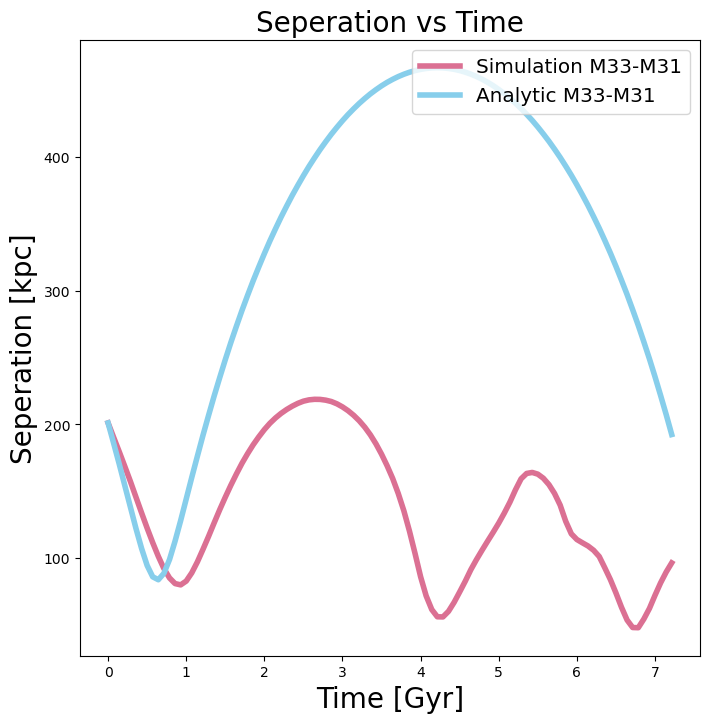

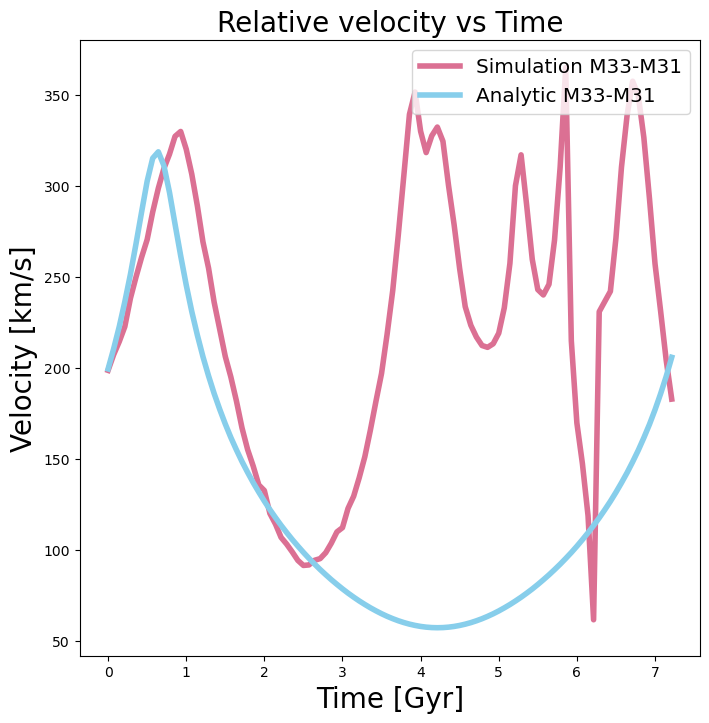

In [471]:
# Plot the Orbit of the galaxies 
#################################

time = np.genfromtxt('Orbit_M33.txt',dtype=None,names=True,skip_header=0,usecols=0)

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)

# plot disk mass profile
plt.plot(time[0:len(M33sep)], sep2[0:len(M33sep)], color='palevioletred', 
         linewidth=4, label='Simulation M33-M31')
plt.plot(time[0:len(M33sep)], M33sep, color='skyblue', linewidth=4, label='Analytic M33-M31')

# Add axis labels
plt.ylabel('Seperation [kpc]', fontsize=20)
plt.xlabel('Time [Gyr]', fontsize=20)

# add title to plot
plt.title('Seperation vs Time', fontsize=20)

#adjust tick label font size
label_size = 20

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')

plt.show()

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)

# plot disk mass profile
plt.plot(time[0:len(M33vel)], vel2[0:len(M33vel)], color='palevioletred', 
         linewidth=4, label='Simulation M33-M31')
plt.plot(time[0:len(M33vel)], M33vel, color='skyblue', 
         linewidth=4, label='Analytic M33-M31')

# Add axis labels
plt.ylabel('Velocity [km/s]', fontsize=20)
plt.xlabel('Time [Gyr]', fontsize=20)

# add title to plot
plt.title('Relative velocity vs Time', fontsize=20)

#adjust tick label font size
label_size = 20

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')

plt.show()

# Question 1: 
# The simulation plots from homework 6 and the analytic plots from this homework are clearly different. They follow similar paths at the beginning and then the analytic plots follow the shape # of the # # simulation plots up until about 4Gyr. Therefore, there are processes that occur after 4Gyr that the analytic solutions do not account for. 

# Question 2: 
# About 4Gyr is when the first close encounter between MW and M31 occurs, therefore it is clear that the absence of MW's dynamical contributions to the system yield a very different M33 orbit.

# Question 3:
# In order to include MW's effects on M33's orbit we could have calculated M33's orbit with respect to both MW and M31 instead of just one or the other. Since both galaxies interact with M33 and with each other, having both galaxies' effects on M33's orbit would be ideal.